In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [26]:
np.logspace(-4,0,endpoint=True,num=10)*101325

array([1.01325000e+01, 2.81942831e+01, 7.84522676e+01, 2.18298095e+02,
       6.07427417e+02, 1.69020287e+03, 4.70308989e+03, 1.30866270e+04,
       3.64143169e+04, 1.01325000e+05])

In [2]:
temps= np.array([280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 
                  290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 
                  300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 
                  310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 
                  320, 321, 322, 323, 324, 325])

In [3]:
C_Ts_pyrads = xr.DataArray(np.zeros(len(temps)), dims=['Ts'], coords={'Ts': temps})

In [4]:
for temp in temps:
    
    arr = np.load(f"co2_{temp}K_1000_logplevs_CO2_continuum_p01dnu.npy")
    C_Ts_pyrads.loc[dict(Ts=temp)]=arr[0]


C_Ts_pyrads

<xarray.DataArray (Ts: 46)>
array([7.90425518e+00, 1.31475939e+01, 2.14284799e+01, 3.44614809e+01,
       5.46747379e+01, 8.49648565e+01, 1.30606605e+02, 1.92914006e+02,
       2.80420455e+02, 3.91451059e+02, 5.39935510e+02, 7.28056890e+02,
       9.61092318e+02, 1.24367837e+03, 1.59318082e+03, 1.98829288e+03,
       2.46138290e+03, 3.00113933e+03, 3.60571857e+03, 4.28650552e+03,
       5.07534534e+03, 5.91128626e+03, 6.86807285e+03, 7.99172231e+03,
       9.18133548e+03, 1.05659532e+04, 1.21204761e+04, 1.39003641e+04,
       1.59845826e+04, 1.82750401e+04, 2.11062575e+04, 2.42637120e+04,
       2.80470946e+04, 3.24501533e+04, 3.77528117e+04, 4.39719050e+04,
       5.14870119e+04, 6.03625679e+04, 7.08720151e+04, 8.36333634e+04,
       9.88432271e+04, 1.17394598e+05, 1.40085489e+05, 1.67460432e+05,
       2.00619578e+05, 2.42220937e+05])
Coordinates:
  * Ts       (Ts) int64 280 281 282 283 284 285 286 ... 320 321 322 323 324 325

(0.0, 1500.0)

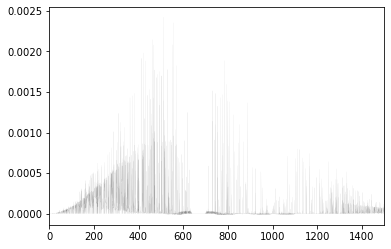

In [18]:
plt.plot(np.arange(0.1, 3500, 0.01), np.load(f"lambdanu_310K_300_logplevs_CO2_continuum_p01dnu.npy"), lw=0.05, color='grey')
plt.xlim(0, 1500)

In [5]:
Ts_C_pyrads = xr.DataArray(temps, dims=['CO2'], 
                           coords={'CO2':xr.DataArray(C_Ts_pyrads.values, dims=['CO2'], attrs={'units':'ppmv'})},
                           attrs={'standard_name': 'Ts', 'units': 'K'})

Text(0.5, 1.0, 'C-T$_{s}$ curve: PyRADS')

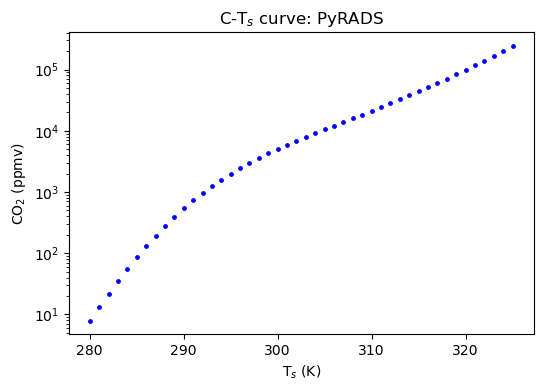

In [6]:
fig, ax = plt.subplots(dpi=100)
        
#ax.scatter(C_Ts_pyrads_100plevs.Ts, C_Ts_pyrads_100plevs, color='k', s=6)

ax.scatter(C_Ts_pyrads.Ts, C_Ts_pyrads, color='blue', s=6)
    
ax.set_yscale('log')

ax.set_ylabel("CO$_{2}$ (ppmv)")

ax.set_xlabel("T$_{s}$ (K)")

ax.set_title("C-T$_{s}$ curve: PyRADS")

In [7]:
da_ECS_pyrads = C_Ts_pyrads.copy()
da_ECS_pyrads.attrs = {'standard_name':'ECS', 'units': 'K'}

In [8]:
for temp in da_ECS_pyrads.Ts:
    conc = C_Ts_pyrads.sel(Ts=temp)
    da_ECS_pyrads.loc[dict(Ts=temp)] = Ts_C_pyrads.interp(CO2=2*conc) - Ts_C_pyrads.sel(CO2=conc) 

Text(0.5, 1.0, 'inferred ECS curve')

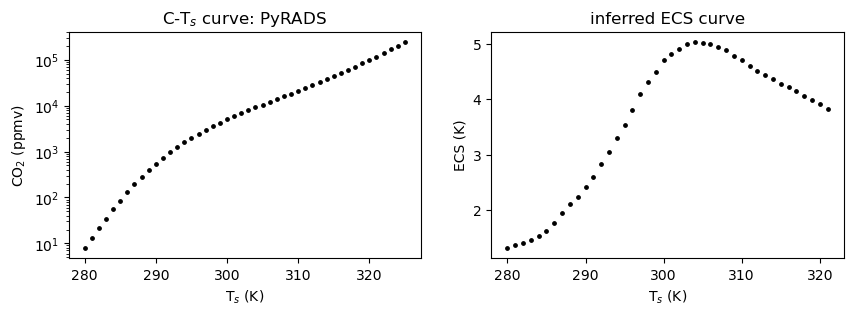

In [9]:
fig, ax = plt.subplots(ncols=2, dpi=100, figsize=(10,3))
        
ax[0].scatter(C_Ts_pyrads.Ts, C_Ts_pyrads, color='k', s=6)

ax[0].set_yscale('log')

ax[0].set_ylabel("CO$_{2}$ (ppmv)")

ax[0].set_xlabel("T$_{s}$ (K)")

ax[0].set_title("C-T$_{s}$ curve: PyRADS")
    
    
ax[1].scatter(da_ECS_pyrads.Ts, da_ECS_pyrads, color='k', s=6)
ax[1].set_ylabel("ECS (K)")

ax[1].set_xlabel("T$_{s}$ (K)")

ax[1].set_title("inferred ECS curve")

#plt.savefig("pyrads_being_weird_v2.png", dpi=200, facecolor='white', bbox_inches='tight')

# PyRADS spectrum

In [9]:
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T):
    return np.divide(params.params.R_a, cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis


""" PyRADS setup """
def calc_olr_pyrads(SST, CO2ppmv, Tstrat=200, dnu=0.1, nu_min=0.1, nu_max=3500, npres=300):
    from scipy.integrate import trapz,simps,cumtrapz

    import pyrads
    class Dummy:
        pass

    params_pyrads = Dummy()

    params_pyrads.Rv = pyrads.phys.H2O.R # moist component
    params_pyrads.cpv = pyrads.phys.H2O.cp
    params_pyrads.Lvap = pyrads.phys.H2O.L_vaporization_TriplePoint
    params_pyrads.satvap_T0 = pyrads.phys.H2O.TriplePointT
    params_pyrads.satvap_e0 = pyrads.phys.H2O.TriplePointP
    params_pyrads.esat = lambda T: pyrads.Thermodynamics.get_satvps(T,
                                                                    params_pyrads.satvap_T0,
                                                                    params_pyrads.satvap_e0,
                                                                    params_pyrads.Rv,
                                                                    params_pyrads.Lvap)

    params_pyrads.R = pyrads.phys.air.R  # dry component
    params_pyrads.R_CO2 = pyrads.phys.CO2.R
    params_pyrads.cp = pyrads.phys.air.cp
    params_pyrads.ps_dry = 1e5           # surface pressure of dry component

    params_pyrads.g = 9.81             # surface gravity
    params_pyrads.cosThetaBar = 3./5.  # average zenith angle used in 2stream eqns
    params_pyrads.RH = 0.8             # relative humidity

    # setup resolution
    N_press = npres
    dwavenr = dnu

    wavenr_min = nu_min  # [cm^-1]
    wavenr_max = nu_max  #

    # setup grid:
    g = pyrads.SetupGrids.make_grid(SST,Tstrat,N_press,
                                    wavenr_min,wavenr_max,dwavenr,
                                    params_pyrads,RH=params_pyrads.RH )

    # Set stratospheric spec hum to tropopause value (approximate)
    if np.any(g.T==Tstrat):
        mask = g.T<=Tstrat
        q_trop = g.q[~mask][0]
        g.q[mask] = q_trop
    
    # compute optical thickness:
    g.tau, g.tau_h2o, g.tau_co2 = pyrads.OpticalThickness.compute_tau_H2ON2_CO2dilute(g.p, g.T, g.q, 
                                                                                      CO2ppmv/1e6, g, 
                                                                                      params_pyrads, RH=params_pyrads.RH)
    # compute Planck functions etc:
    T_2D = np.transpose(np.tile( g.T, (g.Nn,1) )) # shape=(g.p,g.n)
    g.B_surf = np.pi* pyrads.Planck.Planck_n( g.n, SST ) # shape=(g.n)
    g.B = np.pi* pyrads.Planck.Planck_n( g.wave, T_2D ) # shape=(g.p,g.n)
    # compute OLR etc:
    olr_spec = pyrads.Get_Fluxes.Fplus_alternative(0,g) # (spectrally resolved=irradiance)
    olr = simps(olr_spec,g.n)
    
    return olr, olr_spec, g


In [34]:
olr, olr_spec, g = calc_olr_pyrads(SST=320, CO2ppmv=C_Ts_pyrads.sel(Ts=320).values)

compute kappa at p,T =  10.881967447591197 200.0
compute kappa at p,T =  11.222389783683678 200.0
compute kappa at p,T =  11.573461606412538 200.0
compute kappa at p,T =  11.935516065379304 200.0
compute kappa at p,T =  12.308896732158006 200.0
compute kappa at p,T =  12.693957926327434 200.0
compute kappa at p,T =  13.091065051702689 200.0
compute kappa at p,T =  13.500594943085128 200.0
compute kappa at p,T =  13.922936223859743 200.0
compute kappa at p,T =  14.358489674779328 200.0
compute kappa at p,T =  14.807668614285356 200.0
compute kappa at p,T =  15.270899290726511 200.0
compute kappa at p,T =  15.74862128684706 200.0
compute kappa at p,T =  16.241287936928885 200.0
compute kappa at p,T =  16.74936675698305 200.0
compute kappa at p,T =  17.2733398883991 200.0
compute kappa at p,T =  17.813704555473148 200.0
compute kappa at p,T =  18.37097353724884 200.0
compute kappa at p,T =  18.94567565411905 200.0
compute kappa at p,T =  19.538356269649952 200.0
compute kappa at p,T =  20

In [35]:
olrp1, olr_specp1, gp1 = calc_olr_pyrads(SST=321, CO2ppmv=C_Ts_pyrads.sel(Ts=320).values)

compute kappa at p,T =  10.929546389012046 200.0
compute kappa at p,T =  11.271457144773604 200.0
compute kappa at p,T =  11.624063949643203 200.0
compute kappa at p,T =  11.987701409843641 200.0
compute kappa at p,T =  12.362714599137954 200.0
compute kappa at p,T =  12.749459386287151 200.0
compute kappa at p,T =  13.148302772751867 200.0
compute kappa at p,T =  13.559623240958397 200.0
compute kappa at p,T =  13.983811113459586 200.0
compute kappa at p,T =  14.421268923331425 200.0
compute kappa at p,T =  14.872411796156788 200.0
compute kappa at p,T =  15.337667843958855 200.0
compute kappa at p,T =  15.81747857145802 200.0
compute kappa at p,T =  16.312299295037782 200.0
compute kappa at p,T =  16.822599574817215 200.0
compute kappa at p,T =  17.34886366024005 200.0
compute kappa at p,T =  17.891590949603167 200.0
compute kappa at p,T =  18.451296463960606 200.0
compute kappa at p,T =  19.0285113358528 200.0
compute kappa at p,T =  19.623783313324772 200.0
compute kappa at p,T =  

In [37]:
lambdanu_pyrads = xr.DataArray((olr_specp1-olr_spec), dims=['nu'], coords={'nu':g.n})

(-0.005, 0.01)

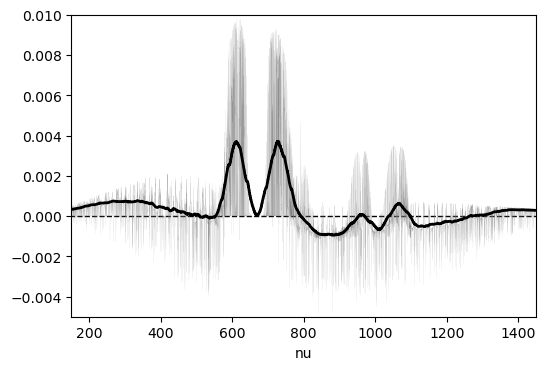

In [46]:
fig, ax = plt.subplots(dpi=100)

lambdanu_pyrads.plot(ax=ax, lw=0.05, color='grey')

lambdanu_pyrads.rolling(nu=500, center=True).mean().plot(ax=ax, lw=2, color='k')

ax.hlines(y=0, xmin=0, xmax=1450, linestyle='--', color='k', lw=1)
ax.set_xlim(150, 1450)
ax.set_ylim(-0.005, 0.01)

In [50]:
%%time
olr2p1, olr_spec2p1, g2 = calc_olr_pyrads(SST=321, CO2ppmv=C_Ts_pyrads.sel(Ts=320).values, dnu=0.02)

olr2, olr_spec2, g2 = calc_olr_pyrads(SST=320, CO2ppmv=C_Ts_pyrads.sel(Ts=320).values, dnu=0.02)

lambdanu_pyrads_0p01dnu = xr.DataArray((olr_spec2p1-olr_spec2), dims=['nu'], coords={'nu':g2.n})

compute kappa at p,T =  10.929546389012046 200.0 using CO2 continuum
compute kappa at p,T =  11.271457144773604 200.0 using CO2 continuum
compute kappa at p,T =  11.624063949643203 200.0 using CO2 continuum
compute kappa at p,T =  11.987701409843641 200.0 using CO2 continuum
compute kappa at p,T =  12.362714599137954 200.0 using CO2 continuum
compute kappa at p,T =  12.749459386287151 200.0 using CO2 continuum
compute kappa at p,T =  13.148302772751867 200.0 using CO2 continuum
compute kappa at p,T =  13.559623240958397 200.0 using CO2 continuum
compute kappa at p,T =  13.983811113459586 200.0 using CO2 continuum
compute kappa at p,T =  14.421268923331425 200.0 using CO2 continuum
compute kappa at p,T =  14.872411796156788 200.0 using CO2 continuum
compute kappa at p,T =  15.337667843958855 200.0 using CO2 continuum
compute kappa at p,T =  15.81747857145802 200.0 using CO2 continuum
compute kappa at p,T =  16.312299295037782 200.0 using CO2 continuum
compute kappa at p,T =  16.82259957

(-0.005, 0.01)

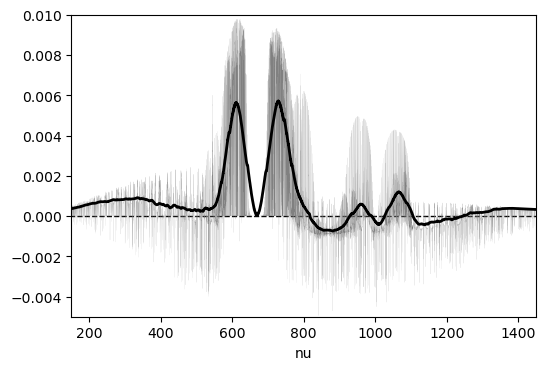

In [52]:
fig, ax = plt.subplots(dpi=100)

lambdanu_pyrads_0p01dnu.plot(ax=ax, lw=0.05, color='grey')

lambdanu_pyrads_0p01dnu.rolling(nu=2500, center=True).mean().plot(ax=ax, lw=2, color='k')

ax.hlines(y=0, xmin=0, xmax=1450, linestyle='--', color='k', lw=1)
ax.set_xlim(150, 1450)
ax.set_ylim(-0.005, 0.01)

In [53]:
lambdanu_pyrads_0p01dnu.integrate('nu')

<xarray.DataArray ()>
array(1.15739986)

In [ ]:
lambdanu_pyrads.integrate('nu')

In [57]:
C_Ts_RFM

<xarray.DataArray (Ts: 46)>
array([8.57182000e+00, 1.39098700e+01, 2.23190600e+01, 3.55074400e+01,
       5.58460700e+01, 8.64093900e+01, 1.30952910e+02, 1.93910040e+02,
       2.80000000e+02, 3.95393240e+02, 5.46167960e+02, 7.38251340e+02,
       9.79185340e+02, 1.27433216e+03, 1.62920706e+03, 2.04819763e+03,
       2.53485794e+03, 3.09218360e+03, 3.72228531e+03, 4.43493839e+03,
       5.22250698e+03, 6.09417727e+03, 7.05494096e+03, 8.11267971e+03,
       9.27869265e+03, 1.05659834e+04, 1.19939544e+04, 1.35833689e+04,
       1.53629322e+04, 1.73658053e+04, 1.96335055e+04, 2.22122014e+04,
       2.51563947e+04, 2.85385641e+04, 3.24304668e+04, 3.69316008e+04,
       4.21469044e+04, 4.81515945e+04, 5.51952377e+04, 6.34130571e+04,
       7.30178220e+04, 8.43288163e+04, 9.74825650e+04, 1.12909957e+05,
       1.31021552e+05, 1.52291214e+05])
Coordinates:
  * Ts       (Ts) int64 280 281 282 283 284 285 286 ... 320 321 322 323 324 325

In [10]:
import pickle

data_path = "../lambdanu_ctrl.pickle"

with open(data_path,mode='rb') as f:
    data = pickle.load(f)

for key,val in data.items():
    exec(key + '=val')

In [11]:
C_Ts_RFM = xr.DataArray(dims=['Ts'], coords={'Ts':np.arange(280,326)})


for t in np.arange(280, 326):
    C_Ts_RFM.loc[dict(Ts=t)] = lambdanu[t]['co2_ppm']


In [12]:
Ts_C_RFM = xr.DataArray(temps, dims=['CO2'], 
                           coords={'CO2':xr.DataArray(C_Ts_RFM.values, dims=['CO2'], attrs={'units':'ppmv'})},
                           attrs={'standard_name': 'Ts', 'units': 'K'})

In [13]:
da_ECS_RFM = C_Ts_RFM.copy()
da_ECS_RFM.attrs = {'standard_name':'ECS', 'units': 'K'}

In [14]:
for temp in da_ECS_RFM.Ts:
    conc = C_Ts_RFM.sel(Ts=temp)
    da_ECS_RFM.loc[dict(Ts=temp)] = Ts_C_RFM.interp(CO2=2*conc) - Ts_C_RFM.sel(CO2=conc) 

Text(0.5, 1.0, 'inferred ECS')

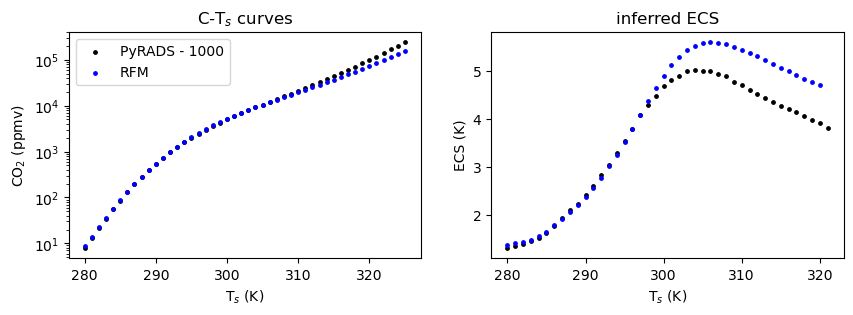

In [15]:
fig, ax = plt.subplots(ncols=2, dpi=100, figsize=(10,3))
        
#ax[0].scatter(C_Ts_pyrads_100_logplevs.Ts, C_Ts_pyrads_100_logplevs, color='k', s=6, label='PyRADS')
ax[0].scatter(C_Ts_pyrads.Ts, C_Ts_pyrads, color='k', s=6, label='PyRADS - 1000')
ax[0].scatter(C_Ts_RFM.Ts, C_Ts_RFM, color='blue', s=6, label='RFM')
ax[0].legend()
ax[0].set_yscale('log')

ax[0].set_ylabel("CO$_{2}$ (ppmv)")

ax[0].set_xlabel("T$_{s}$ (K)")

ax[0].set_title("C-T$_{s}$ curves")
    
    
    
ax[1].scatter(da_ECS_pyrads.Ts, da_ECS_pyrads, color='k', s=6)
ax[1].scatter(da_ECS_RFM.Ts, da_ECS_RFM, color='blue', s=6)

ax[1].set_ylabel("ECS (K)")

ax[1].set_xlabel("T$_{s}$ (K)")

ax[1].set_title("inferred ECS")

#plt.savefig("pyrads_being_weird_vs_RFM_v3_300logplevs.png", dpi=200, facecolor='white', bbox_inches='tight')

In [68]:
import climlab

In [75]:
state = climlab.column_state(num_lev=1000, num_lat=1, water_depth=1.)
plevs = state['Tatm'].domain.axes['lev'].points

In [76]:
plevs

array([5.000e-01, 1.500e+00, 2.500e+00, 3.500e+00, 4.500e+00, 5.500e+00,
       6.500e+00, 7.500e+00, 8.500e+00, 9.500e+00, 1.050e+01, 1.150e+01,
       1.250e+01, 1.350e+01, 1.450e+01, 1.550e+01, 1.650e+01, 1.750e+01,
       1.850e+01, 1.950e+01, 2.050e+01, 2.150e+01, 2.250e+01, 2.350e+01,
       2.450e+01, 2.550e+01, 2.650e+01, 2.750e+01, 2.850e+01, 2.950e+01,
       3.050e+01, 3.150e+01, 3.250e+01, 3.350e+01, 3.450e+01, 3.550e+01,
       3.650e+01, 3.750e+01, 3.850e+01, 3.950e+01, 4.050e+01, 4.150e+01,
       4.250e+01, 4.350e+01, 4.450e+01, 4.550e+01, 4.650e+01, 4.750e+01,
       4.850e+01, 4.950e+01, 5.050e+01, 5.150e+01, 5.250e+01, 5.350e+01,
       5.450e+01, 5.550e+01, 5.650e+01, 5.750e+01, 5.850e+01, 5.950e+01,
       6.050e+01, 6.150e+01, 6.250e+01, 6.350e+01, 6.450e+01, 6.550e+01,
       6.650e+01, 6.750e+01, 6.850e+01, 6.950e+01, 7.050e+01, 7.150e+01,
       7.250e+01, 7.350e+01, 7.450e+01, 7.550e+01, 7.650e+01, 7.750e+01,
       7.850e+01, 7.950e+01, 8.050e+01, 8.150e+01, 

280 [9.573053]
281 [15.31263016]
282 [24.08393894]
283 [36.98424288]
284 [55.22105271]
285 [104.96254367]
286 [150.63375492]
287 [208.70266816]
288 [279.5]
289 [363.53647497]
290 [457.4562503]
291 [739.48502606]
292 [916.11625664]
293 [1108.36210705]
294 [1307.03579745]
295 [1500.56624616]
296 [2246.05220972]
297 [2591.47871965]
298 [2923.46481279]
299 [3219.13512759]
300 [3453.19497477]
301 [3601.11505559]
302 [5428.64580211]
303 [5860.17174434]
304 [6205.66206607]
305 [6405.17519614]
306 [6425.91986259]
307 [6242.3709554]
308 [10078.78668024]
309 [10637.45301599]
310 [11003.46865853]
311 [11088.18683302]
312 [10818.60990915]
313 [10166.70520599]
314 [9177.01028617]
315 [18732.63584934]
316 [22219.75468934]
317 [26571.65741774]
318 [31904.01541883]
319 [38248.03015757]
320 [45668.91794662]


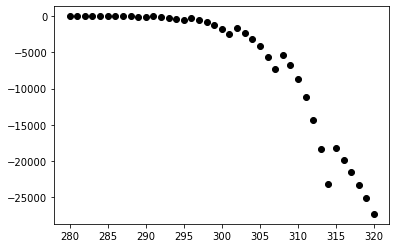

In [10]:
import os

fig, ax = plt.subplots()

for temp in temps:

    arr = np.load(f"co2_{temp}K.npy")
    print(temp, arr)
        
    #ax.scatter(temp, arr, color='k')
    ax.scatter(temp, arr[0]-C_Ts.sel(Ts=temp), color='k')
    
    
#ax.scatter(C_Ts.Ts, C_Ts, color='red')
#ax.set_yscale('log')